# LAB 1: ANN and PyTorch [62 pts]

In this lab, you will start off by constructing a neural networks from scratch to get a stronger understanding of what is required to make neural networks work.

The first part of the lab involves building a neural network from scratch to gain a better understanding of how they work. The second part of the lab involves training a neural network using PyTorch to classify images as either "cat" or "dog".  The code for the neural networks you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: 

# PART A: Constructing a Neural Network [15 pt]

Before we get into using PyTorch to train our classifier we will go through the process of creating our neural network from scratch. We've seen in the tutorial how to build a 1-layer network, now we'll take it one step further to build a 2-layer network. This is an important exercise that everyone should attempt at least once to understand and truly appreciate the workings of neural networks.

## Part A.0 Helper Functions

To help guide the construction we will use the iris dataset that was introduced in the tutorial. Provided are some helper code to get us started:

In [141]:
# load "Iris_3class.csv" to Google Colab
# from google.colab import files
# uploaded = files.upload()

In [142]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv("Iris_3class.csv", header = None)
raw_data = raw_data.values
np.random.shuffle(raw_data)

In [143]:
import numpy as np
# raw_data = raw_data.values

# split your data into training and validation
X_train = raw_data[0:100,:4]
y_train = raw_data[0:100,4:5].astype(int)
X_val = raw_data[100:,:4]
y_val = raw_data[100:,4:5].astype(int)

print(X_train.shape, y_train.shape)
print(X_train.dtype, y_train.dtype)
print(X_val.shape, y_val.shape)
print(X_val.dtype, y_val.dtype)

(100, 4) (100, 1)
float64 int32
(50, 4) (50, 1)
float64 int32


Recall that the neural network output consists of several nodes, one for each output class. Since the labels are provided as integers we will need to convert them into one-hot vectors to match the neural network output format.

In [144]:
#Convert array to one-hot encoding
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

In [145]:
y_train = to_one_hot(y_train)
print(X_train.shape, y_train.shape)
print(X_train.dtype, y_train.dtype)

y_val = to_one_hot(y_val)
print(X_val.shape, y_val.shape)
print(X_val.dtype, y_val.dtype)

(100, 4) (100, 3)
float64 float64
(50, 4) (50, 3)
float64 float64


In [146]:
#verify one-hot encoding
y_train[0:5,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

## Part A.1 Develop a 2-layer ANN [5 pt]
At its core a 2-layer neural network is just a few lines of code. Most of the complexity comes from setting up the training of the network.

Using vectorized form, set up the neural network training to use a cross-entropy loss function and determine the gradients with resepect to the layer 1 and layer 2 weights.

In [150]:
# write code to create a 2-layer ANN in vectorized form

#define sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

#define softmax
def softmax(x):
  e = np.exp(x)
  return e/e.sum(axis=1, keepdims = True)


def ann(W, X_train, y_train):    
  num_hidden_nodes = 5
  num_input_features = 4
  num_output_classes = 3

  num_samples = X_train.shape[0]

  #Extracting Weights
  hidden_layer_weights = W[:20].reshape(num_input_features, num_hidden_nodes)
  output_layer_weights = W[20:].reshape(num_hidden_nodes, num_output_classes)

  #Feed Forward
  input_layer = X_train
  hidden_layer = sigmoid(np.dot(input_layer, hidden_layer_weights))
  raw_output = np.dot(hidden_layer, output_layer_weights)

  #Activation Function: Softmax
  model_output = softmax(raw_output)
    
  #Backpropagation and Gradient Descent
    
  #Loss Function: Cross-Entropy
  loss = np.sum(-y_train*np.log(model_output))
  #Initialize Gradients to Zero
  dw_hidden = 0
  dw_output = 0
  
  #Calculate Gradients
  error_signal = model_output - y_train
  error_signal = error_signal.reshape(num_samples, num_output_classes, 1)
  hidden_layer = hidden_layer.reshape(num_samples, 1, num_hidden_nodes)

  dw_output_samples = error_signal @ hidden_layer
  dw_output = np.sum(dw_output_samples, axis = 0)
  
  weighted_error = error_signal * output_layer_weights.T
  hidden_error = np.sum(weighted_error, axis = 1)

  hidden_layer = hidden_layer.squeeze()
  input_layer = input_layer.reshape(num_samples, 1, num_input_features)

  dw_hidden_samples = (hidden_error * hidden_layer * (1 - hidden_layer)).reshape(num_samples,num_hidden_nodes,1) * input_layer

  dw_hidden = np.sum(dw_hidden_samples, axis = 0)

  #Combine Gradients into One Vector
  gradients = np.array(list(dw_hidden.flatten()) + list(dw_output.flatten()))
    
  return (loss, gradients, model_output)



## Part A.2 Train your neural network. How well does your network work on the iris dataset? [5 pt]

Part A.2 of the lab assignment is focused on training the neural network that was created in Part 1. The code initializes the number of hidden units, features, and outputs. Then it initializes random weights for the two layers of the network, and combines them into a single vector W. 

In [151]:
num_hidden = 5
num_features = 4
num_outputs = 3
  
#initialize weights
w0 = 2*np.random.random((num_features, num_hidden)) - 1
w1 = 2*np.random.random((num_hidden, num_outputs)) - 1

#combine weights into a single vector
W = np.array(list(w0.flatten()) + list(w1.flatten()))

#train network
n = 0.001
iterations = 100000
errors = []
for i in range(iterations):
  (error, dW, y_pred) = ann(W, X_train, y_train)
  W += -dW * n
  errors.append(error)

print("Error: {}".format(errors[-1]))

Error: 44.347627511001676


In [152]:
#examine predictions on training data
(_, _, y_pred) = ann(W, X_train, y_train)
pred = np.round(y_pred, 0)
pred[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [153]:
#examine ground truth training data
train = np.round(y_train, 0)
train[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [157]:
#compare the two
correct_matches = np.mean(np.equal(train, pred))
print("{}% of the arrays correctly match up!".format(correct_matches*100))

79.33333333333333% of the arrays correctly match up!


## Part A.3 Validate that the gradients were computed correctly for the 2-layer neural network you developed. [5 pt]

Part A.3 is focused on validating the gradients computed for the 2-layer neural network. The code initializes random weights for the two layers of the network and combines them into a single vector W. It then computes the gradients analytically using the ann() function, and then computes the gradients numerically. The code does this by slightly incrementing the weights and computing the errors for each increment. 

In [159]:
#write code to numerical verify the gradients you calculated

num_hidden = 5
num_features = 4
num_outputs = 3
  
#initialize weights
w0 = 2*np.random.random((num_features, num_hidden)) - 1
w1 = 2*np.random.random((num_hidden, num_outputs)) - 1

#combine weights
W = np.concatenate((w0.flatten(), w1.flatten()))

#compute gradients analytically
(error, dW, y_pred) = ann(W, X_train, y_train)

#compute gradients numerically
dW_num = np.zeros((len(W),1))

for ind in range(len(W)):
  #reset gradients
  We1 = np.array(list(w0.flatten()) + list(w1.flatten()))
  We2 = np.array(list(w0.flatten()) + list(w1.flatten()))
  
  #increment slightly
  We1[ind] = We1[ind] + 1e-5
  We2[ind] = We2[ind] - 1e-5
  
  #compute errors
  (error_e1, dW_e1, y_pred1) = ann(We1, X_train, y_train)
  (error_e2, dW_e2, y_pred2) = ann(We2, X_train, y_train)
  
  #obtain numerical gradients
  grad_num = (error_e1 - error_e2) / (2 * 1e-5)
  
  #display difference between numerical and analytic gradients
  print(round(abs(grad_num - dW[ind]), 4), grad_num, dW[ind])


0.0 -12.032657329541506 -12.03265733483472
2.3372 -5.664537498972776 -3.327350019924061
13.0036 -0.027828876625335393 -13.031448210296267
2.5652 -1.536942915691952 -4.102191194106082
5.6614 -0.0031392367816351903 -5.664537499873401
0.9651 -3.3273500193331524 -2.3622135117710563
2.3269 -2.3622135117307153 -4.689153210290434
1.4626 -0.02570452366512654 -1.48828550417687
1.1091 -1.1369739382871558 -0.027828876998908385
0.0245 -0.0011910955777238996 -0.025704524356482645
13.038 -13.03144821065416 0.006520531039867319
4.6936 -4.689153210790664 0.0044412207909547054
1.5435 0.006520531314890831 -1.536942914389376
0.8985 -0.23842801724072157 -1.136973937780365
0.236 -0.0024431301426375285 -0.23842801794239085
4.1103 -4.102191195443083 0.00806518574753464
1.4851 -1.488285504080977 -0.0031392367975712505
0.0056 0.004441220369244547 -0.0011910952740302792
0.0105 0.0080651858525016 -0.0024431305949379235
0.0 -0.0006826816445482108 -0.0006826818987401407
0.0 14.343598292043678 14.34359829158889
3.2

# PART B: Cats vs Dogs [47 pt]

In Part B of the lab, we will use PyTorch to train a neural network to identify cats and Dogs. The code starts by importing some libraries, including numpy, torch, and torchvision. This section provides some helper functions for loading and preprocessing the data.

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part B.0 Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [3]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 9
        label_class = classes[label_index] # ex: 'truck'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cat and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part B.1 Visualizing the Data [5 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [4]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part B.1.a - [1 pt]

Visualize some of the data by running the code below.
Include the visualization in your writeup.

Your figures should show up directly in the jupyter notebook.

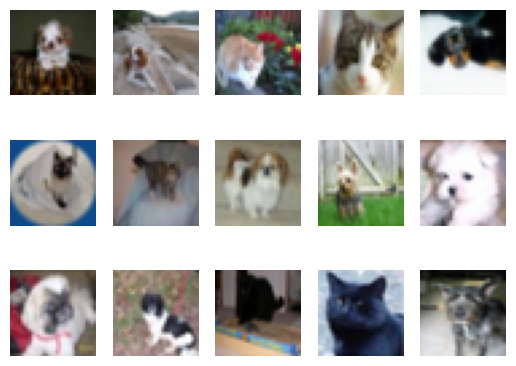

In [5]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part B.1.b - [2 pt]

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [22]:
print("Training examples: {}".format(len(train_loader)))
print("Validation examples: {}".format(len(val_loader)))
print("Validation examples: {}".format(len(test_loader)))

Training examples: 8000
Validation examples: 2000
Validation examples: 2000


### Part B.1.c - [2pt]

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [24]:
"""
Overfit training data, giving unrealistic idea of how it will work in the real world, 
when exposed to new datapoints it has not seen before
"""

'\nOverfit training data, giving unrealistic idea of how it will work in the real world, \nwhen exposed to new datapoints it has not seen before\n'

## Part B.2 Training [10 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [25]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [26]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [27]:
small_net = SmallNet()
large_net = LargeNet()

### Part B.2.a - [1pt]

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [29]:
total_params_large = 0
for name, param in large_net.named_parameters():
    if param.requires_grad:
        total_params_large += param.numel()

print("large_net has {} parameters".format(total_params_large))

total_params_small = 0
for name, param in small_net.named_parameters():
    if param.requires_grad:
        total_params_small += param.numel()

print("small_net has {} parameters".format(total_params_small))

large_net has 9705 parameters
small_net has 386 parameters


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [30]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats and dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part B.2.b - [1pt]

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [32]:
"""
Batch_size_default = 64
learning_rate_default = 0.01
num_epochs_default = 30
"""

'\nBatch_size_default = 64\nlearning_rate_default = 0.01\nnum_epochs_default = 30\n'

### Part B.2.c - [1 pt]

What files stored in memory when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [120]:
"""
The function train_net trains the SmallNet model and writes the model checkpoints to disk after each epoch. 
The model checkpoints contain the learned parameters of the model at the end of each epoch. 
The list of all the files written to disk are:

small_run_bs64_lr0.01_e1.pth
small_run_bs64_lr0.01_e2.pth
small_run_bs64_lr0.01_e3.pth
small_run_bs64_lr0.01_e4.pth
small_run_bs64_lr0.01_e5.pth

Also, it writes the train/test loss/err into CSV file for plotting later:
{model_path}_train_err.csv
{model_path}_train_loss.csv
{model_path}_val_err.csv
{model_path}_vall_loss.csv
"""

'\nThe function train_net trains the SmallNet model and writes the model checkpoints to disk after each epoch. \nThe model checkpoints contain the learned parameters of the model at the end of each epoch. \nThe list of all the files written to disk are:\n\nsmall_run_bs64_lr0.01_e1.pth\nsmall_run_bs64_lr0.01_e2.pth\nsmall_run_bs64_lr0.01_e3.pth\nsmall_run_bs64_lr0.01_e4.pth\nsmall_run_bs64_lr0.01_e5.pth\n\nAlso, it writes the train/test loss/err into CSV file for plotting later:\n{model_path}_train_err.csv\n{model_path}_train_loss.csv\n{model_path}_val_err.csv\n{model_path}_vall_loss.csv\n'

### Part B.2.d - [2pt]

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

# from google.colab import drive
# drive.mount('/content/gdrive')

In [33]:
train_net(small_net)
"""Total Elapsed Time: 99.91sec"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42225, Train loss: 0.6716893286705017 |Validation err: 0.3735, Validation loss: 0.6535375118255615
Epoch 2: Train err: 0.363125, Train loss: 0.6403151378631592 |Validation err: 0.3635, Validation loss: 0.6488180924206972
Epoch 3: Train err: 0.344375, Train loss: 0.6254550428390503 |Validation err: 0.3455, Validation loss: 0.6202895045280457
Epoch 4: Train err: 0.33075, Train loss: 0.6105197143554687 |Validation err: 0.352, Validation loss: 0.623590836301446
Epoch 5: Train err: 0.325375, Train loss: 0.60311017203331 |Validation err: 0.3315, Validation loss: 0.6158160287886858
Epoch 6: Train err: 0.313125, Train loss: 0.5944882760047913 |Validation err: 0.33, Validation loss: 0.6116951555013657
Epoch 7: Train err: 0.316125, Train loss: 0.5916760983467102 |Validation err: 0.3345, Validation loss: 0.6108628995716572
Epoch 8: Train err: 0.3085, Train loss: 0.5859797523021698 |Validation err: 0.

In [66]:
large_net = LargeNet()

train_net(large_net)
"""Total Time elapsed: 100.23sec
This network took longer to train, likely due to the increased number of parameters needed to train it (9705 vs 386)
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203142166138 |Validation err: 0.4285, Validation loss: 0.6807542890310287
Epoch 2: Train err: 0.419125, Train loss: 0.6781901922225952 |Validation err: 0.413, Validation loss: 0.6741813980042934
Epoch 3: Train err: 0.39825, Train loss: 0.6658477659225464 |Validation err: 0.3895, Validation loss: 0.6517984792590141
Epoch 4: Train err: 0.374, Train loss: 0.6491091041564941 |Validation err: 0.415, Validation loss: 0.6685771699994802
Epoch 5: Train err: 0.356625, Train loss: 0.6333016548156738 |Validation err: 0.355, Validation loss: 0.629199018701911
Epoch 6: Train err: 0.34075, Train loss: 0.616297025680542 |Validation err: 0.3395, Validation loss: 0.6153793297708035
Epoch 7: Train err: 0.32625, Train loss: 0.6006992321014404 |Validation err: 0.332, Validation loss: 0.6069300677627325
Epoch 8: Train err: 0.31175, Train loss: 0.583225442647934 |Validation err: 0.323, 

'Total Time elapsed: 100.23sec\nThis network took longer to train, likely due to the increased number of parameters needed to train it (9705 vs 386)\n'

### Part B.2.e - [2pt]

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [67]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

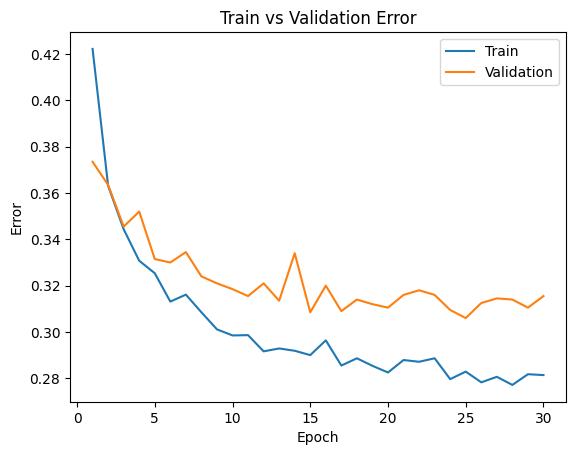

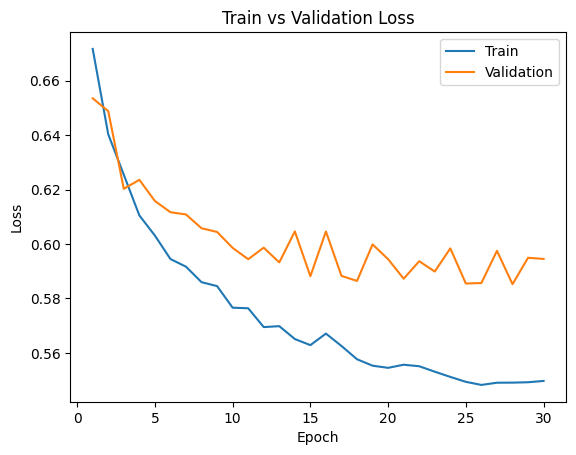

In [68]:
plot_training_curve(model_path_small)

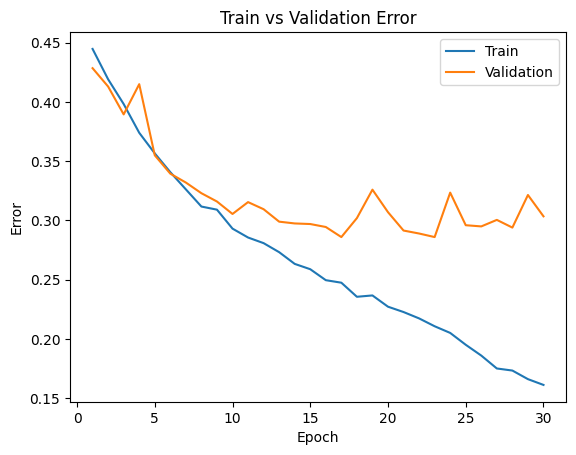

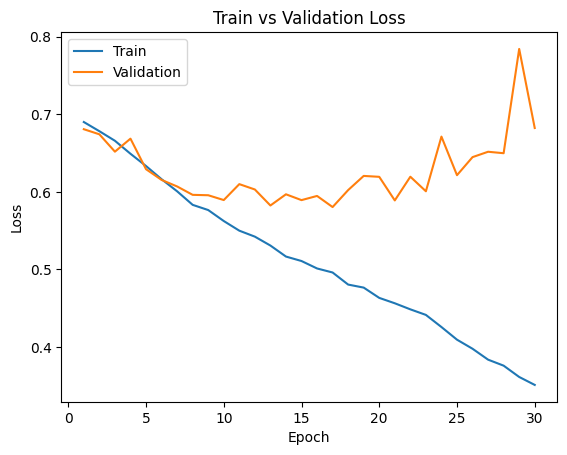

In [69]:
plot_training_curve(model_path_large)

### Part B.2.f - [3pt]

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
"""
small_net: Slightly underfits, as the validation error does not decrease super closely to the training error, i.e. the validation data plateus earlier than the training error
large_net: Significantly overfits the training data! The loss during training significantly decreaases, while the validation stays consistantly high
"""

## Part B.3 Optimization Parameters [4 pt]

For this section, we will work with `large_net` only.

### Part B.3.a - [1pt]

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [46]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate=0.001)

"""
model now takes 102.53 seconds to train, longer compared to the training rate of 0.01
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.694520537853241 |Validation err: 0.491, Validation loss: 0.6929904241114855
Epoch 2: Train err: 0.50225, Train loss: 0.6930276718139649 |Validation err: 0.491, Validation loss: 0.692411782220006
Epoch 3: Train err: 0.48725, Train loss: 0.6922526645660401 |Validation err: 0.4765, Validation loss: 0.6920249667018652
Epoch 4: Train err: 0.4485, Train loss: 0.6916850352287293 |Validation err: 0.452, Validation loss: 0.6913791038095951
Epoch 5: Train err: 0.44225, Train loss: 0.6910664744377136 |Validation err: 0.441, Validation loss: 0.6910907663404942
Epoch 6: Train err: 0.439875, Train loss: 0.6903701310157776 |Validation err: 0.438, Validation loss: 0.690503753721714
Epoch 7: Train err: 0.438, Train loss: 0.6895477037429809 |Validation err: 0.4345, Validation loss: 0.6896886937320232
Epoch 8: Train err: 0.439, Train loss: 0.6884630904197693 |Validation err: 0.434, Valid

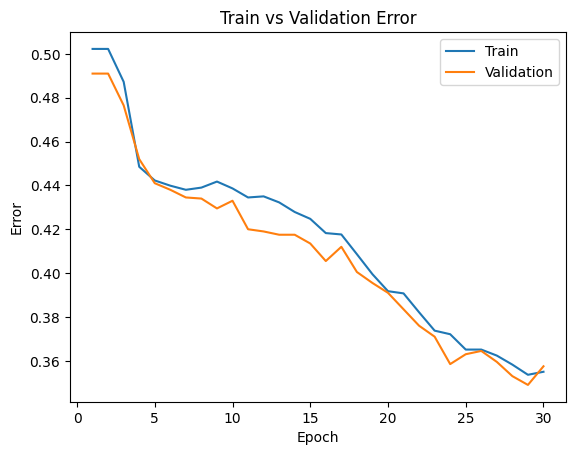

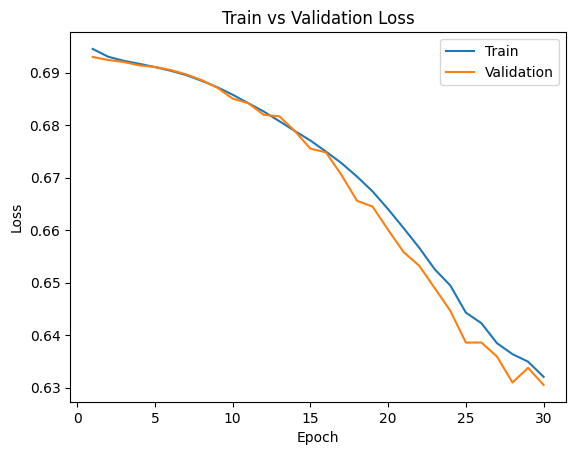

'\nDecreasing the learning rate resulted in slower training, and \n'

In [47]:
model_path_large_r0_001 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large_r0_001)
"""
Decreasing the learning rate typically results in slower training. In our case, it resulted in being able to better converge to a lower validation error and less overfitting. 
"""

### Part B.3.b - [1pt]

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [49]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)
"""
Model now takes 103.13 seconds to train, which is technically longer when compared to the earlier 0.01 learning rate
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.465625, Train loss: 0.686097309589386 |Validation err: 0.4165, Validation loss: 0.6748904455453157
Epoch 2: Train err: 0.3885, Train loss: 0.6563922820091248 |Validation err: 0.4335, Validation loss: 0.7253238949924707
Epoch 3: Train err: 0.3785, Train loss: 0.6472749264240265 |Validation err: 0.347, Validation loss: 0.6192699670791626
Epoch 4: Train err: 0.349, Train loss: 0.6209026646614074 |Validation err: 0.3545, Validation loss: 0.6235557552427053
Epoch 5: Train err: 0.340875, Train loss: 0.6098622360229492 |Validation err: 0.3335, Validation loss: 0.606679292395711
Epoch 6: Train err: 0.32475, Train loss: 0.5987818586826325 |Validation err: 0.335, Validation loss: 0.6185094621032476
Epoch 7: Train err: 0.311625, Train loss: 0.5870607025623321 |Validation err: 0.3435, Validation loss: 0.6211186423897743
Epoch 8: Train err: 0.30525, Train loss: 0.572433467388153 |Validation err: 0.346,

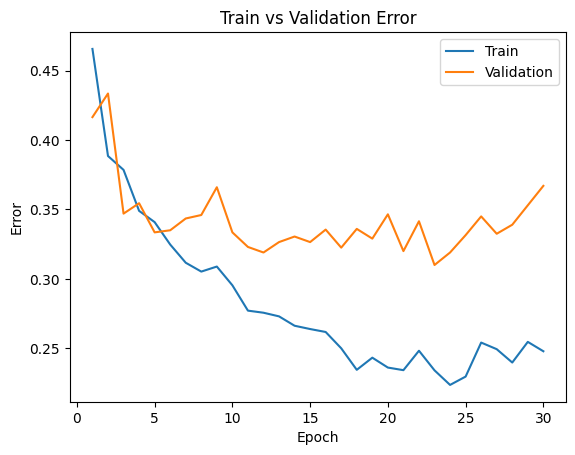

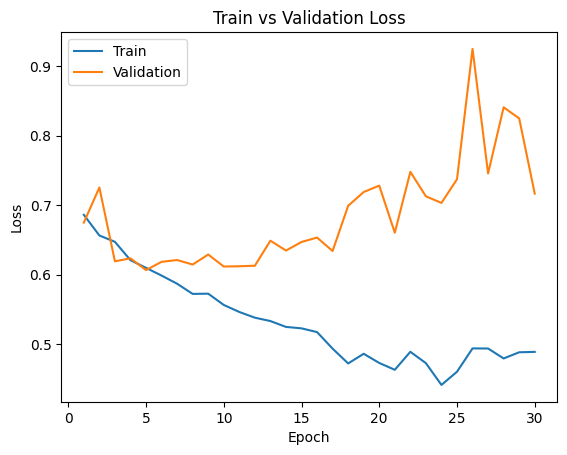

'\nincreasing the learning rate typically results in faster convergence. \nIn our case, it resulted in a worse convergence between the trainingh and validation error over time \n'

In [51]:
model_path_large_r0_1 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large_r0_1)
"""
increasing the learning rate typically results in faster convergence. 
In our case, it resulted in a worse convergence between the trainingh and validation error over time
The validation loss is also spiking as the number of epochs increase 
"""

### Part B.3.c - [1pt]

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [52]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.01, batch_size=512)

"""
model now takes 101.24 seconds to train, longer compared to the batch rate of 16 (100.23)
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379478096962 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425394058228
Epoch 3: Train err: 0.437, Train loss: 0.691650040447712 |Validation err: 0.4265, Validation loss: 0.6909129768610001
Epoch 4: Train err: 0.433625, Train loss: 0.6908450089395046 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936409175396 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.688353419303894 |Validation err: 0.428, Validation loss: 0.6860130578279495
Epoch 7: Train err: 0.439375, Train loss: 0.6866870857775211 |Validation err: 0.426, Validation loss: 0.6836969554424286
Epoch 8: Train err: 0.435375, Train loss: 0.6849769651889801 |Validation err: 0.412, V

'\nmodel now takes  seconds to train, longer compared to the batch rate of 64\n'

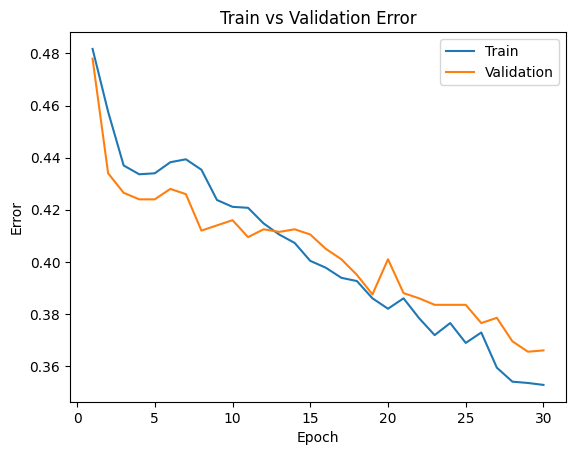

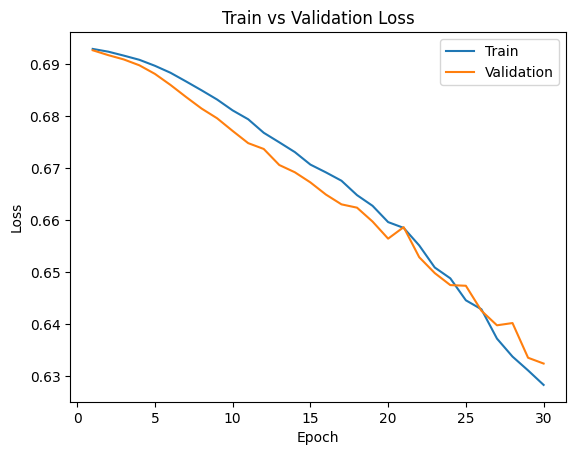

'\nIncreasing the batch size resulted in a similar overal lvalidation loss when compared against the \n'

In [55]:
model_path_large_b512 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_b512)
"""
Increasing the batch size resulted in a similar overal validation loss when compared against the 0.001 learning rate
It also resulted in faster training on the training data
"""

### Part B.3.d - [1pt]

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [56]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.01, batch_size=16)

"""
model now takes 115.38 seconds to train, longer compared to the batch size of 64
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6776098057031631 |Validation err: 0.3745, Validation loss: 0.6529334602355957
Epoch 2: Train err: 0.3665, Train loss: 0.6401842282414436 |Validation err: 0.349, Validation loss: 0.6164464230537414
Epoch 3: Train err: 0.34125, Train loss: 0.613589223921299 |Validation err: 0.3525, Validation loss: 0.6413086023330689
Epoch 4: Train err: 0.31725, Train loss: 0.587400611281395 |Validation err: 0.333, Validation loss: 0.5950916383266449
Epoch 5: Train err: 0.304125, Train loss: 0.5666579261422158 |Validation err: 0.3125, Validation loss: 0.5752839140892029
Epoch 6: Train err: 0.284125, Train loss: 0.5436721180677414 |Validation err: 0.303, Validation loss: 0.5860224282741546
Epoch 7: Train err: 0.269125, Train loss: 0.5239313088655472 |Validation err: 0.3115, Validation loss: 0.593790715932846
Epoch 8: Train err: 0.26075, Train loss: 0.5082529461979866 |Validation err: 0.3

'\nmodel now takes  seconds to train, longer compared to the batch rate of 64\n'

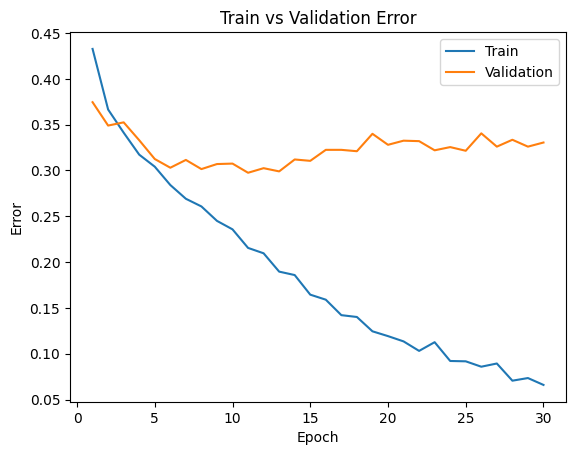

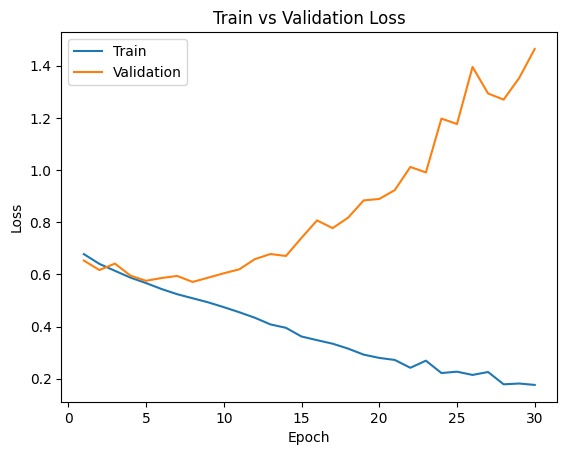

'\ndecreasing the batch size resulted in a longer training time, and more significant overfitting.\n'

In [58]:
model_path_large_b16 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_b16)
"""
decreasing the batch size resulted in a longer training time, and more significant overfitting.
The validation error and loss do not converge similarly to the training data, a sign of overfitting
"""

## Part B.4 Hyperparameter Search [4 pt]

### Part B.4.a - [1pt]

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [59]:
"""
network: large_net
batch_size: 512
learning_rate: 0.001

These parameters were selected as individually, they resulted in the best overall validation errors and losses,
so bringing them all together may result in an optimal solution that brings the best all together
"""

'\nlarge_net:\n'

### Part B.4.b - [1pt]

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [60]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677369236946 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280571639538 |Validation err: 0.493, Validation loss: 0.6929539740085602
Epoch 4: Train err: 0.477, Train loss: 0.6928808428347111 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.6927744187414646 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896311342716 |Validation err: 0.472, Validation loss: 0.6926551908254623
Epoch 7: Train err: 0.46325, Train loss: 0.6926203668117523 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435625016689 |Validation err: 0.463, 

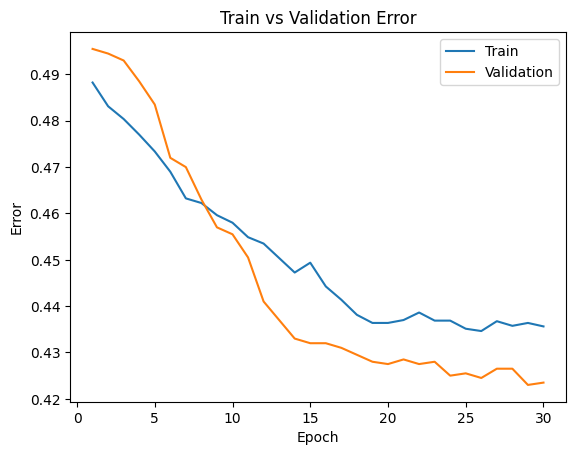

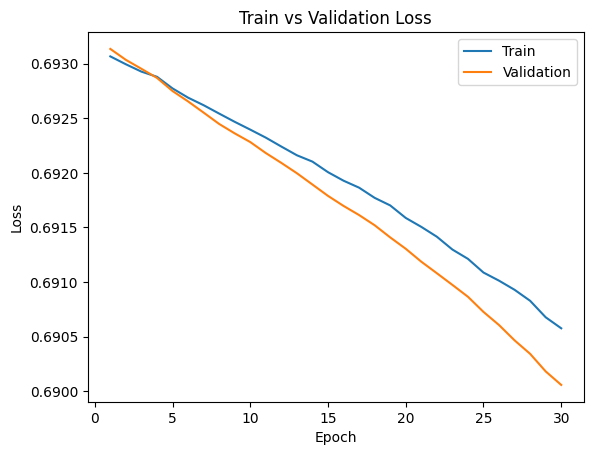

In [61]:
model_path_large_r0_001_b512 = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large_r0_001_b512)

### Part B.4.c - [1pt]

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [64]:
"""
network: small_net
batch_size: 512
learning_rate: 0.001

changing the network to small net. This is because the model is currently overfitting, so by moving to a more simple
network we reduce the chance of overfitting due to an extremely complicated network

However we do run the risk of having too simple of a network, one that is not able to actually complete the classification task 
"""

'\nnetwork: small_net\nbatch_size: 512\nlearning_rate: 0.001\n\nchanging the network to small net. This is because the model is currently overfitting, so by moving to a more simple\nnetwork we reduce the chance of overfitting due to an extremely complicated network\n\nHowever we do run the risk of having too simple of a network, one that does not  \n'

### Part B.4.d - [1pt]

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [63]:
large_net=LargeNet()
small_net = SmallNet()
train_net(small_net,batch_size=512, learning_rate=0.001 )

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49025, Train loss: 0.6936734654009342 |Validation err: 0.4835, Validation loss: 0.6922099441289902
Epoch 2: Train err: 0.4795, Train loss: 0.6923303231596947 |Validation err: 0.4695, Validation loss: 0.6906939148902893
Epoch 3: Train err: 0.4825, Train loss: 0.6915928535163403 |Validation err: 0.4615, Validation loss: 0.6900605410337448
Epoch 4: Train err: 0.4785, Train loss: 0.6910254620015621 |Validation err: 0.459, Validation loss: 0.6895719915628433
Epoch 5: Train err: 0.474, Train loss: 0.6905792392790318 |Validation err: 0.455, Validation loss: 0.6889778822660446
Epoch 6: Train err: 0.469125, Train loss: 0.6901449859142303 |Validation err: 0.453, Validation loss: 0.6885827779769897
Epoch 7: Train err: 0.464625, Train loss: 0.6896504685282707 |Validation err: 0.4555, Validation loss: 0.6879503130912781
Epoch 8: Train err: 0.46225, Train loss: 0.6892056725919247 |Validation err: 0.45, 

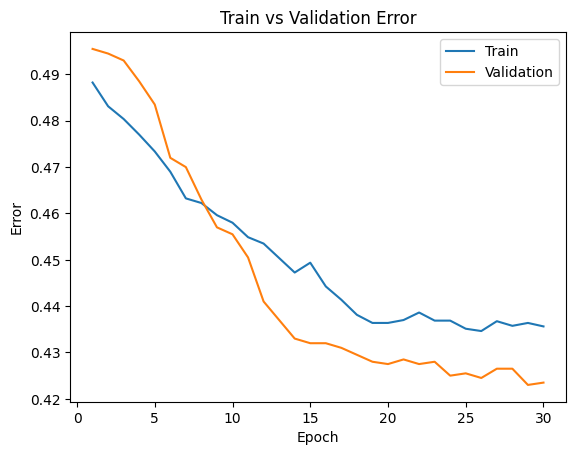

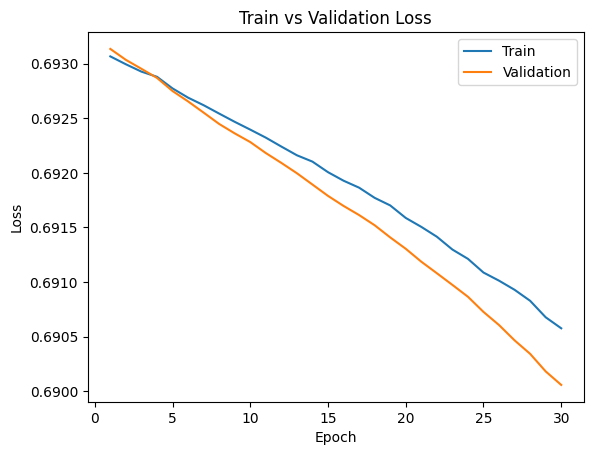

In [65]:
model_path_small_r0_001_b512 = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_small_r0_001_b512)

## Part B.5 Evaluating the Best Model [9 pt]


### Part B.5.a - [1pt]

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [70]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.001, epoch=10)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part B.5.b - [2pt]

Justify your choice of model from part (a).

In [72]:
"""
These hyperparameters were chosen because they resulted in the best graphs, characterized by the lowest 
validation errors, with a 0.366 minimum. This was ideal verson the other tested hyperparameters and many of 
the other selected options tended to significant overfit to the testing data
"""

'\nThese hyperparameters were chosen because they resulted in the best graphs, characterized by the lowest \nvalidation errors, with a 0.366 minimum. This was ideal verson the other tested hyperparameters and many of \nthe other selected options tended to significant overfit to the testing data\n'

### Part B.5.c - [2pt]

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [74]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [75]:
test_error, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())

print("Test classification error is: {}%".format(test_error*100))

Test classification error is: 41.65%


### Part B.5.d - [2pt]

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [78]:
val_error, val_loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())

print("Val classification error is: {}%".format(val_error*100))

Val classification error is: 42.0%


In [79]:
"""
Typically we would expect test error to be higher than validation error because it 
uses never before seen data. Validation error is used during hyperparameter tuning, 
as such, when deciding its weights, we end up 'seeing' the validation data.

In our case the test error is actualy slightly smaller than the val classification error
(41.65% vs 42.0%), which may just be random occurance
"""

"\nTypically we would expect test error to be higher than validation error because it \nuses never before seen data. Validation error is used during hyperparameter tuning, \nas such, when deciding its weights, we end up 'seeing' the validation data.\n\nIn our case the test error is actualy slightly smaller than the val classification error\n"

### Part B.5.e - [2pt]

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
"""
Because once we use the test data it is no longer a true test of the model's accuracy for 
new and unseen data.
As mentioned, the model will learn from any images it sees, and that includes the test data
"""

## Part B.6 Fully-Connected Linear ANN vs CNN [9 pt]

Test out a 3-layer linear fully-connected ANN architecture (see simpleANN below). You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.


### Part B.6.a - [3 pt]

How does the your best CNN model compare with an 2-layer linear ANN model (no convolutional layers) on classifying cat and dog images?

In [81]:
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(32*32*3, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)
                
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [101]:
# Trying with base parameters
three_ann = simpleANN()
train_net(three_ann)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422125, Train loss: 0.670931194782257 |Validation err: 0.396, Validation loss: 0.6549723967909813
Epoch 2: Train err: 0.378375, Train loss: 0.6430702724456787 |Validation err: 0.3905, Validation loss: 0.657450782135129
Epoch 3: Train err: 0.3605, Train loss: 0.6298680944442749 |Validation err: 0.3805, Validation loss: 0.6399181373417377
Epoch 4: Train err: 0.3415, Train loss: 0.6163095350265503 |Validation err: 0.409, Validation loss: 0.6730025988072157
Epoch 5: Train err: 0.32475, Train loss: 0.6014623231887818 |Validation err: 0.388, Validation loss: 0.6431433856487274
Epoch 6: Train err: 0.30625, Train loss: 0.5849793729782105 |Validation err: 0.382, Validation loss: 0.6576524972915649
Epoch 7: Train err: 0.301125, Train loss: 0.5702813880443574 |Validation err: 0.3765, Validation loss: 0.6515577044337988
Epoch 8: Train err: 0.279, Train loss: 0.5433137032985688 |Validation err: 0.3585,

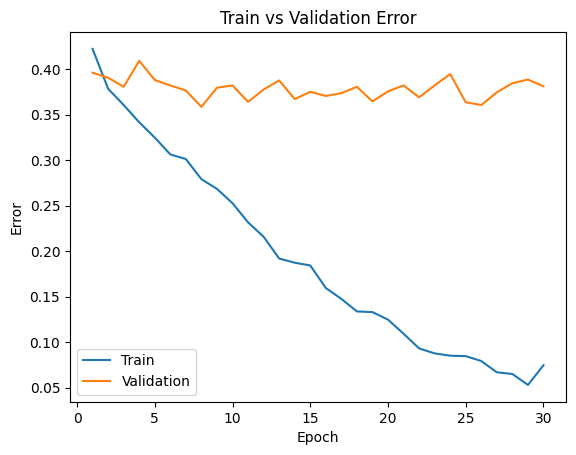

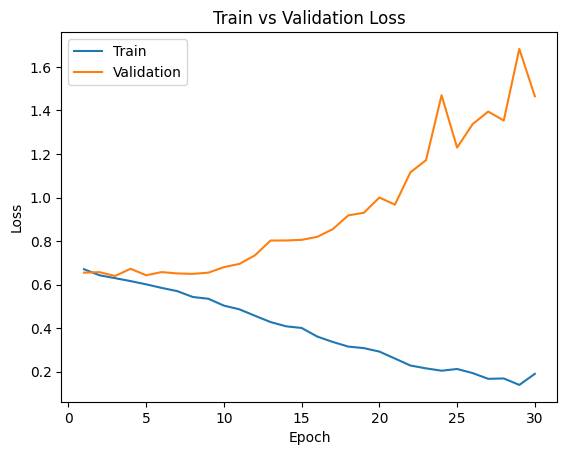

In [102]:
model_path_ann_std = get_model_name("simple", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_ann_std)

In [ ]:
"""
The ANN significantly overfits, not as good as the earlier best CNN model
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4325, Train loss: 0.6771632206439971 |Validation err: 0.4085, Validation loss: 0.6639444146156311
Epoch 2: Train err: 0.39175, Train loss: 0.6547258800268173 |Validation err: 0.3935, Validation loss: 0.656760661125183
Epoch 3: Train err: 0.377125, Train loss: 0.642149436712265 |Validation err: 0.379, Validation loss: 0.6480420517921448
Epoch 4: Train err: 0.359, Train loss: 0.6316326776146889 |Validation err: 0.3915, Validation loss: 0.6558038005828858
Epoch 5: Train err: 0.350375, Train loss: 0.6232110249400139 |Validation err: 0.377, Validation loss: 0.643006638765335
Epoch 6: Train err: 0.331875, Train loss: 0.6109366219043731 |Validation err: 0.395, Validation loss: 0.6563417229652405
Epoch 7: Train err: 0.321625, Train loss: 0.6001881155371666 |Validation err: 0.3735, Validation loss: 0.6426954057216644
Epoch 8: Train err: 0.313375, Train loss: 0.5879596658945083 |Validation err: 0.36

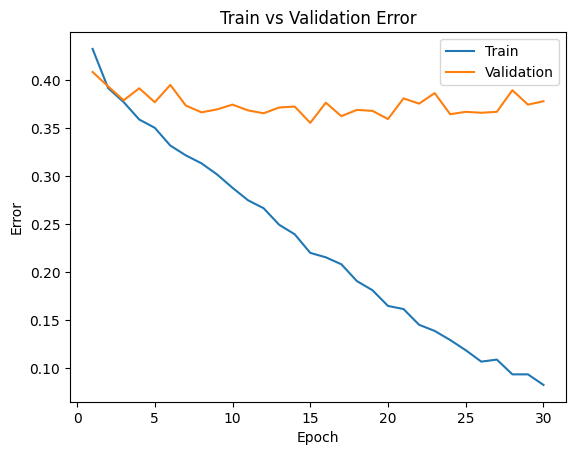

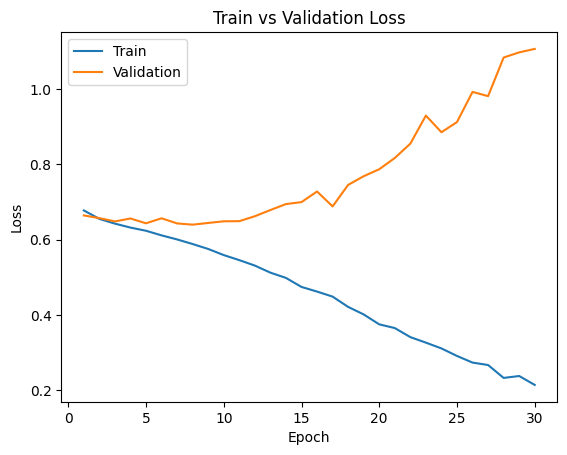

In [103]:
#Trying with different batch and learning rate
three_ann = simpleANN()
train_net(three_ann, batch_size=16, learning_rate=0.001)
model_path_ann_16_0_001 = get_model_name("simple", batch_size=16, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_ann_16_0_001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6932339034974575 |Validation err: 0.503, Validation loss: 0.6939976662397385
Epoch 2: Train err: 0.4865, Train loss: 0.6917219124734402 |Validation err: 0.4875, Validation loss: 0.6923671364784241
Epoch 3: Train err: 0.462625, Train loss: 0.6900944821536541 |Validation err: 0.4675, Validation loss: 0.6906638443470001
Epoch 4: Train err: 0.447875, Train loss: 0.6883732043206692 |Validation err: 0.4565, Validation loss: 0.6890359222888947
Epoch 5: Train err: 0.433, Train loss: 0.686623677611351 |Validation err: 0.452, Validation loss: 0.6873900592327118
Epoch 6: Train err: 0.427, Train loss: 0.6851451843976974 |Validation err: 0.4435, Validation loss: 0.6857898384332657
Epoch 7: Train err: 0.421, Train loss: 0.6837005317211151 |Validation err: 0.438, Validation loss: 0.6843086332082748
Epoch 8: Train err: 0.41725, Train loss: 0.6823090687394142 |Validation err: 0.4305, V

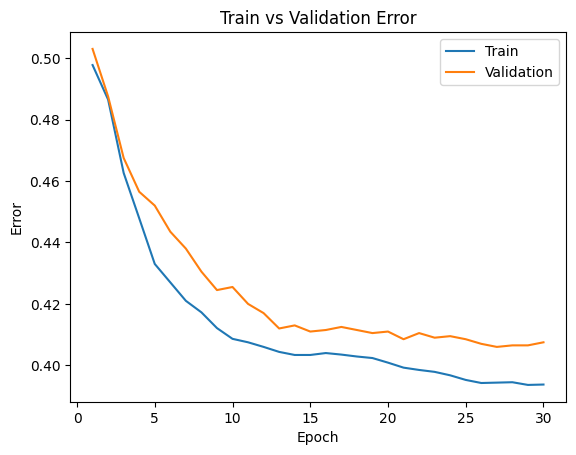

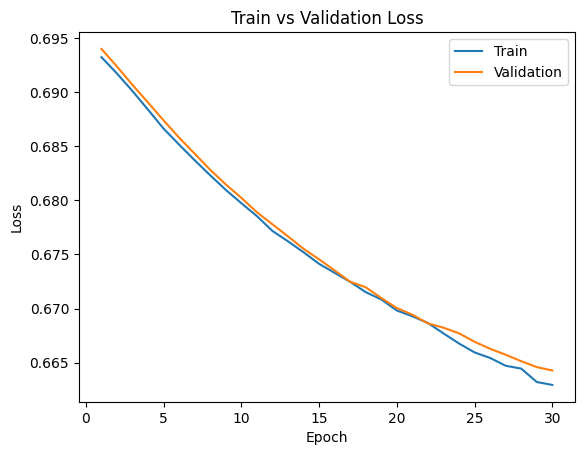

In [105]:
#Lots of overfitting, so will try increasing batch size
three_ann = simpleANN()
train_net(three_ann, batch_size=512, learning_rate=0.001)
model_path_ann_512_0_001 = get_model_name("simple", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_ann_512_0_001)

In [ ]:
"""
this model with the following parameters had the best validation data results, and 
will be used to compare against the test dataset
"""

In [106]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [107]:
test_error, test_loss = evaluate(three_ann, test_loader, nn.BCEWithLogitsLoss())

print("Test classification error is: {}%".format(test_error*100))

Test classification error is: 40.050000000000004%


In [ ]:
"""
The test classification error of this ANN is technically higher than the earlier best CNN
"""

### Part B.6.b - [6 pt]

Implement a 3-layer ANN architecture with dropout and batch normalization (separately). Compare the performance of this model with the simpleANN model provided above.

In [88]:
# define model here
class dropANN(nn.Module):
    def __init__(self):
        super(dropANN, self).__init__()
        self.name = "simple_drop"
        self.fc1 = nn.Linear(32*32*3, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)
        self.dropout = nn.Dropout(0.2) #20% chance of dropout

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.501375, Train loss: 0.7018701620399952 |Validation err: 0.491, Validation loss: 0.6964887976646423
Epoch 2: Train err: 0.499875, Train loss: 0.6983305029571056 |Validation err: 0.4895, Validation loss: 0.6954080760478973
Epoch 3: Train err: 0.495625, Train loss: 0.6952209025621414 |Validation err: 0.4795, Validation loss: 0.6922241896390915
Epoch 4: Train err: 0.4905, Train loss: 0.6924284100532532 |Validation err: 0.4835, Validation loss: 0.6894114315509796
Epoch 5: Train err: 0.482875, Train loss: 0.6902572996914387 |Validation err: 0.4795, Validation loss: 0.6881358921527863
Epoch 6: Train err: 0.473125, Train loss: 0.6874684430658817 |Validation err: 0.4675, Validation loss: 0.6861840188503265
Epoch 7: Train err: 0.4675, Train loss: 0.6861673034727573 |Validation err: 0.4605, Validation loss: 0.6847722977399826
Epoch 8: Train err: 0.45625, Train loss: 0.6846051588654518 |Validation err

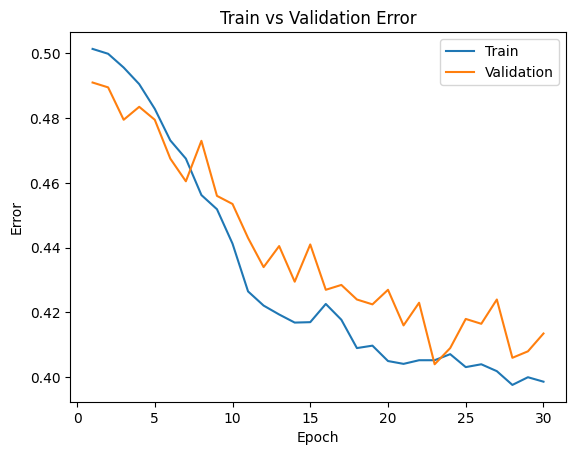

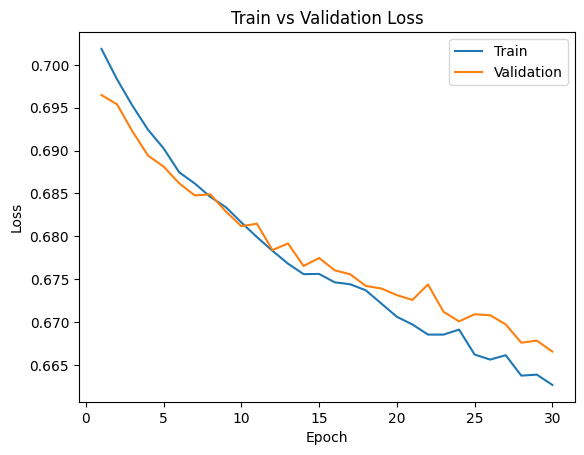

In [112]:
# perform your comparison here

drop_ann = dropANN()
train_net(drop_ann, batch_size=512, learning_rate=0.001)
model_path_adrop_512_0_001 = get_model_name("simple_drop", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_adrop_512_0_001)

In [98]:
#defining Batch normalization model

class batchANN(nn.Module):
    def __init__(self):
        super(batchANN, self).__init__()
        self.name = "batch"
        self.fc1 = nn.Linear(32*32*3, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 20)
        self.bn2 = nn.BatchNorm1d(20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [110]:
batch_ann = batchANN()

train_net(batch_ann, batch_size=512, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4685, Train loss: 0.6907339133322239 |Validation err: 0.4335, Validation loss: 0.6836263835430145
Epoch 2: Train err: 0.410375, Train loss: 0.6680336147546768 |Validation err: 0.422, Validation loss: 0.6692517995834351
Epoch 3: Train err: 0.384625, Train loss: 0.655124869197607 |Validation err: 0.407, Validation loss: 0.6640403568744659
Epoch 4: Train err: 0.372875, Train loss: 0.6462502554059029 |Validation err: 0.403, Validation loss: 0.659376934170723
Epoch 5: Train err: 0.368875, Train loss: 0.6389662213623524 |Validation err: 0.4035, Validation loss: 0.6572026312351227
Epoch 6: Train err: 0.356375, Train loss: 0.6329905241727829 |Validation err: 0.3945, Validation loss: 0.6534019410610199
Epoch 7: Train err: 0.35175, Train loss: 0.6267332024872303 |Validation err: 0.394, Validation loss: 0.6518917828798294
Epoch 8: Train err: 0.345125, Train loss: 0.621926736086607 |Validation err: 0.

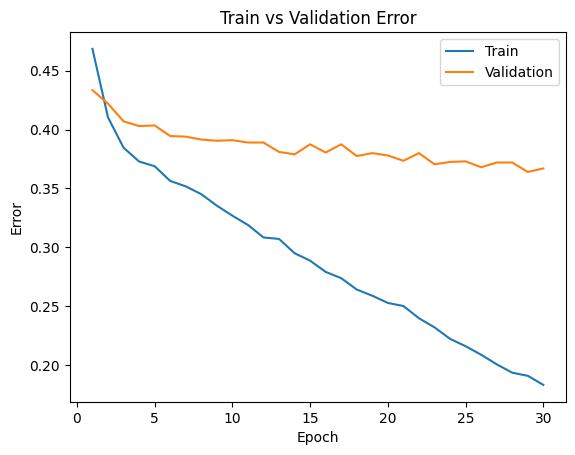

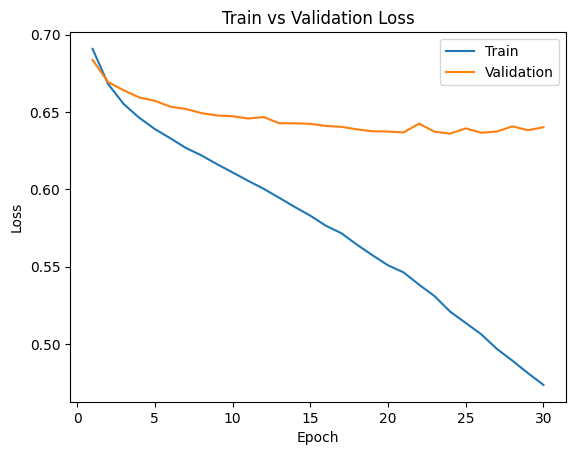

In [111]:
model_path_abatch_512_0_001 = get_model_name("batch", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_abatch_512_0_001)

In [ ]:
"""
The overall best ANN model with lowest validation error was the dropout ANN
Its test error is tested below
"""

In [113]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

test_error, test_loss = evaluate(drop_ann, test_loader, nn.BCEWithLogitsLoss())

print("Test classification error is: {}%".format(test_error*100))

Files already downloaded and verified
Files already downloaded and verified
Test classification error is: 41.05%


## Part B.7-Conceptual Questions [6 pt]

### Part B.7.a - [3 pt]

Explain the difference between L1 and L2 regularization and when it is appropriate to use one over the other. How would you implement L1 regularization in simpleANN?


In [121]:
"""
L1 and L2 regularization are techniques used to prevent overfitting in neural networks by 
adding a penalty term to the loss function during training. L1 regularization adds the absolute 
value of the weights to the loss, while L2 adds the square of the weights. L1 is best used 
when you have sparse data, as it encourages the model to have sparse weights. L2 is best used 
when you have dense data, as it encourages the model to have small weights. 

To implement L1 regularization in the simpleANN model, I would add a term to the loss 
function that penalizes the absolute value of the weights in the network. Similar to below
"""

class annL1(nn.Module):
    def __init__(self, lambda_l1):
        super(annL1, self).__init__()
        self.name = "annL1"
        self.fc1 = nn.Linear(32*32*3, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)
        self.lambda_l1 = lambda_l1

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

    def l1_penalty(self):
        return self.lambda_l1 * (
            torch.norm(self.fc1.weight, p=1) + 
            torch.norm(self.fc2.weight, p=1) + 
            torch.norm(self.fc3.weight, p=1)
        )

### Part B.7.b - [3 pt]

Describe the impact of different activation functions (e.g. ReLU, Sigmoid, Tanh) on the performance of the model. How would you go about choosing the appropriate activation function for simpleANN?

In [122]:
"""
- ReLU activation is widely used due to its simplicity and ability to alleviate the vanishing gradient problem. 
- Sigmoid activation is also commonly used, especially in binary classification problems, but its outputs are 
limited to the range (0, 1) and can lead to the vanishing gradient problem. 
- Tanh activation is similar to sigmoid, but its range is (-1, 1), making it more suitable for certain tasks. 

The appropriate activation function for a particular model depends on the nature of the problem, such as the range of the output values and the desired level of non-linearity. 

The most intuitive way to choose the appropriate activation fuinction would be to test out the different functions and comparing the results of the validation
set at the same hyperparameter space.
"""

'\n- ReLU activation is widely used due to its simplicity and ability to alleviate the vanishing gradient problem. \n- Sigmoid activation is also commonly used, especially in binary classification problems, but its outputs are \nlimited to the range (0, 1) and can lead to the vanishing gradient problem. \n- Tanh activation is similar to sigmoid, but its range is (-1, 1), making it more suitable for certain tasks. \n\nThe appropriate activation function for a particular model depends on the nature of the problem, such as the range of the output values and the desired level of non-linearity. \n\nThe most intuitive way to choose the appropriate activation fuinction would be to test out the different functions and comparing the results of the validation\nset at the same hyperparameter space.\n'

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_1_ANN_and_PyTorch.ipynb

(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus